There has been a hype around cryptocurrency in the past few months and I do have FOMO. This project is nice for me to review my econometrics knowledge, flex out some data analysis muscle, and try out some forecasting techniques to increase my odd in the market. 


I will start the project with a review of Stationarity and some tests, then move to EDA, and some models to predict future trends. Now let's get started!

- Data Loading
- Stationarity 
- EDA
- Model building
- Conclusion




# 1.  Loading Bitcoin Data


In [126]:
!pip install python-binance

In [127]:
import os
from binance.client import Client
import pandas as pd
import numpy as np 
import math
import random
from collections import deque

from dateutil import parser
from tqdm import tqdm_notebook


from sklearn import preprocessing

# init
api_key = os.environ.get('binace_api')
api_secret = os.environ.get('binance_secret')

client = Client(api_key, api_secret)
# CONSTANTS
BIN_SIZE = {"1m":1,"5m":5,"1h":60,"1d":1440}
BATCH_SIZE = 750


import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

In [128]:
def classify(current, future):
  '''
  classify investment decision: buy if future price is higher than spot price
  '''
  if float(future) > float(current):
    return 1
  else:
    return 0

# 1. Getting Bitcoin data using Binance API

In [129]:
# get latest price from Binance API
btc_price = client.get_symbol_ticker(symbol="BTCUSDT")
# print full output (dictionary)
print(btc_price)

{'symbol': 'BTCUSDT', 'price': '64297.54000000'}


In [130]:
## FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
  '''
  find the diff between last saved data (if any) and the newest data
  '''
  # check if data file existed -> take the latest timestamp
  if len(data)>0: old = parser.parse(data["timestamp"].iloc[-1])
  # if old data doesn't exist -> consider 1/1/2017 as starting point
  elif source == "binance": old = datetime.strptime('1 Jan 2017','%d %b %Y')
  if source == "binance": new = pd.to_datetime(
      client.get_klines(
          symbol=symbol, 
          interval=kline_size)[-1][0],
          unit='ms'
      )
  return old,new


def get_all_binance(symbol, kline_size, save=False):
  '''
  pull crypto data based on symbol and kline
  if save = True -> export dataframe as csv
  if save = False -> export dataframe 
  '''
  filename = '%s-%s-data.csv'%(symbol,kline_size)
  # read directly if file existed 
  if os.path.isfile(filename): data_df = pd.read_csv(filename)
  else: data_df = pd.DataFrame()

  oldest_point , newest_point = minutes_of_new_data(
      symbol,
      kline_size, 
      data_df,
      source="binance"
      )
  
  delta_min = (newest_point - oldest_point).total_seconds()/60
  available_data = math.ceil(delta_min/BIN_SIZE[kline_size])
  if oldest_point == datetime.strptime('1 Jan 2017','%d %b %Y'):
    print('Downloading all available data for %s data for %s. Be patients...!'
    %(kline_size,symbol))
  else:
    print('Downloading %d minutes of new data available for %s\
    ,ie. %d instances of %s data.'%(delta_min,symbol,available_data, kline_size)
    )
  klines = client.get_historical_klines(symbol,kline_size,\
                                        oldest_point.strftime(
                                            "%d %b %Y %H:%M:%S"
                                            ),
                                        newest_point.strftime(
                                            "%d %b %Y %H:%M:%S"
                                        )
                                        )
  bar_cols = ['timestamp',
            'open',
            'high',
            'low',
            'close',
            'volume',
            'close_time',
            'quote_asset_volume',
            'number_of_trades',
            'taker_buy base asset volume',
            'taker buy quote asset volume',
            '_']
  data = pd.DataFrame(klines,columns = bar_cols)
  data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
  if len(data_df) > 0:
    temp_df = pd.DataFrame(data)
    data_df = data_df.append(temp_df)
  else: data_df = data

  data_df.set_index('timestamp',inplace=True)
  if save: data_df.to_csv(filename)
  print('All caught up..!')
  return data_df




In [131]:
btc_data_1d = get_all_binance("BTCUSDT","1d",save=True)
# btc_data_5m = pd.read_csv('BTCUSDT-5m-data.csv')
btc_data_1d.head()

All caught up..!


,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy base asset volume,taker buy quote asset volume,_
timestamp,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.15,1503014399999,3.45477e+06,3427,616.249,2.67822e+06,8733.91
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.89,1503100799999,5.08696e+06,5233,972.869,4.12912e+06,9384.14
2017-08-19,4108.37,4184.69,3850,4139.98,381.31,1503187199999,1.54948e+06,2153,274.336,1.118e+06,9184.09
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083,1503273599999,1.93036e+06,2321,376.796,1.5574e+06,10125.4
2017-08-21,4069.13,4119.62,3911.79,4016,691.743,1503359999999,2.79723e+06,3972,557.356,2.25566e+06,11706.8


In [157]:
main_df = get_all_binance("BTCUSDT","1d",save=True)
# btc_data_5m = pd.read_csv('BTCUSDT-5m-data.csv')
np.array(main_df.close,dtype=float) < 0

All caught up..!


array([False, False, False, ..., False, False, False])

In [158]:
main_df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy base asset volume,taker buy quote asset volume,_
timestamp,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.15,1503014399999,3.45477e+06,3427,616.249,2.67822e+06,8733.91
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.89,1503100799999,5.08696e+06,5233,972.869,4.12912e+06,9384.14
2017-08-19,4108.37,4184.69,3850,4139.98,381.31,1503187199999,1.54948e+06,2153,274.336,1.118e+06,9184.09
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083,1503273599999,1.93036e+06,2321,376.796,1.5574e+06,10125.4
2017-08-21,4069.13,4119.62,3911.79,4016,691.743,1503359999999,2.79723e+06,3972,557.356,2.25566e+06,11706.8


In [133]:
btc_data_5m = get_all_binance("BTCUSDT","5m",save=True)
# btc_data_5m = pd.read_csv('BTCUSDT-5m-data.csv')
btc_data_5m.head()

All caught up..!


,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy base asset volume,taker buy quote asset volume,_
timestamp,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.18906,1502942699999,9333.62,9,0.489061,2089.1,7960.38
2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0,1502942999999,0,0,0,0,7959.63
2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0,1502943299999,0,0,0,0,7958.42
2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666,1502943599999,2065.45,9,0.085455,364.218,7958.35
2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.32857,1502943899999,9931.16,11,1.54649,6595.69,7953.97


In [134]:
os.listdir()


['.config',
 'BTCUSDT-5m-data.csv',
 'drive',
 'BTCUSDT-1d-data.csv',
 'sample_data']

# 2. Data Analysis 

**Time Series Decomposition**
Time Series can be decomposed into multiple components:
- Level: The average value in the series
- Trend: The increasing/ decreasing value in the series
- Seasonality: The repeating short-term cycle in the series
- Noise: The random variation in the series

## 2.1 Stationarity Analysis
Stationarity means that the statistical properties of a time series (or the process generating it) do not change over time. Stationarity is a characteristic of stochastic process. -> the ability to deterine whether a time series is stationary is important. 


## Ways to test for stationarity

#### i) Visual


#### ii) Parametric test
**Unit Root Test**
If a time series has some sort of trend, level, or seasonality, it will need to a Unit Root. The Unit Root makes a time series more unpredictable and it would be useful to remove this unit root.

*The Dickey-Fuller test*
- null hypothesis is present in an autoregressive model of a given time series

*The KPSS Test*
- assume stationary around a mean/ linear trend

*The Zivot and Andrew Test*
- allow break point; unit root test in which they assume the break-point is unknown










In [135]:
#import data_prep_helper
import plotly.graph_objects as go
#import plot_helper as ph
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

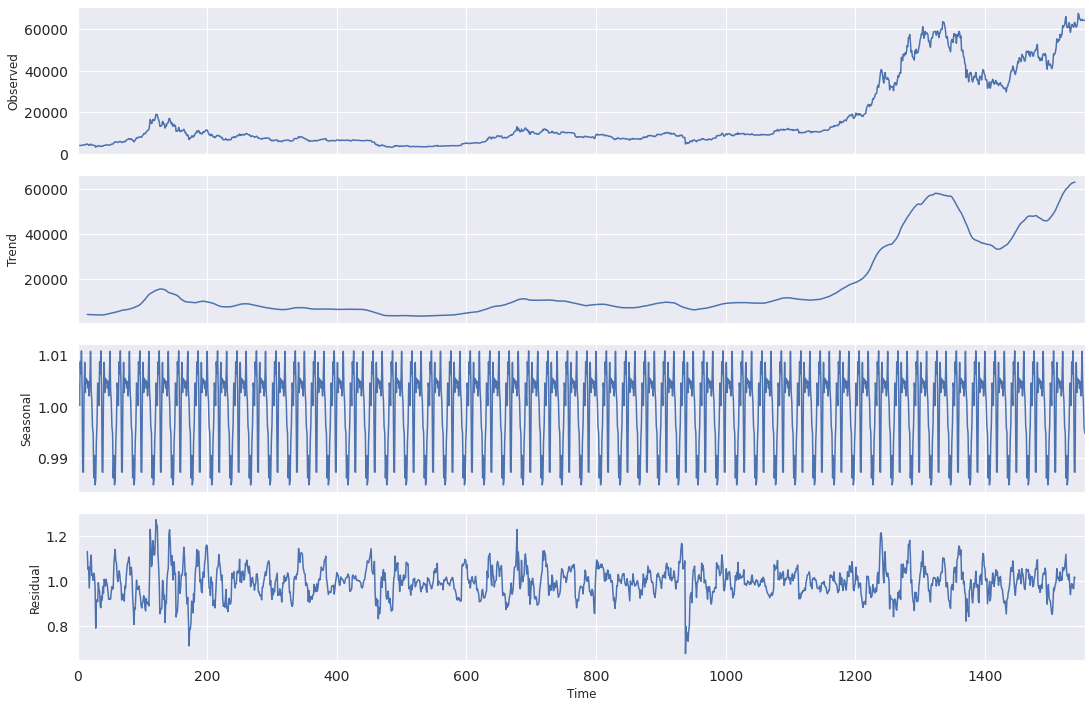

In [136]:
# btc_month = btc_data_5m.resample('M').mean()
# btc_month.head()

btc_series = pd.DataFrame(data=btc_data_1d['close'].values, 
                          index=pd.to_datetime(btc_data_1d.index),
                          columns=['close']
                          ).dropna()


# Resampling to monthly frequency

result = seasonal_decompose(np.array(btc_series.values, dtype=float),
                            model='multiplicative',
                            freq=30)
result.plot()
fig = plt.gcf()
fig.set_size_inches(15,10,forward=True)   

In [137]:
print("Dickey-Fullter test: p=%f" % adfuller(np.array(btc_series.close, 
                                                      dtype=float),
                                             maxlag=MAX_LAG, autolag=None
                                             )[1])


Dickey-Fullter test: p=0.973626


 **Conclusions from Seasonality Decomposition**

 It can be easily seen from the plots that Bitcoin price is highly volatile and therefore has high residuals. 


## 3. Data Pre-processing

**Box-Cox Transformation**

The Box-Cox transformation is a familiy of power transformations indexed by a parameter lambda. This transformation helps suppress some of the variance.

Sometimes the Box-Cox transformation is insufficient to stationarize the timeseries, diagnostics from ARIMA modeling can be used to decide if defferencing or seasonal differencing might be useful to remove polynomial/ seasonal trends respectively. 

In [138]:
# Box-Cox Transformations
btc_series['close_box'], lmbda = stats.boxcox(np.array(btc_series.close,
                                                       dtype=float))
print("Dickey–Fuller test: p=%f" % adfuller(btc_series.close_box,
                                            maxlag=MAX_LAG, autolag=None)[1])

Dickey–Fuller test: p=0.691802


### Differencing



In [154]:
# Seasonal differentiation (3 months)
btc_series['box_diff_seasonal_3'] = btc_series.close_box - btc_series.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_series.box_diff_seasonal_3[3:],
                                            maxlag=MAX_LAG, autolag=None)[1])

Dickey–Fuller test: p=0.000000


In [155]:
# Seasonal differentiation (12 months)
btc_series['box_diff_seasonal_12'] = btc_series.close_box - btc_series.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_series.box_diff_seasonal_12[12:],
                                            maxlag=MAX_LAG, autolag=None)[1])

Dickey–Fuller test: p=0.000000


## 4. Monthly Forecasting

### ARIMA Model

AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:



```
p - the number of lag observations to include in the model, or lag order. (AR)
d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
q - the size of the moving average window, also called the order of moving average.(MA)
```



A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates to not use that element of the model.

In [141]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_series.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [142]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())


  parameters           aic
6     (2, 0) -19569.889588
2     (0, 2) -19569.722700
7     (2, 1) -19567.983080
5     (1, 2) -19567.878290
4     (1, 1) -19567.661592


In [143]:
print(best_model.summary())


                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                 1555
Model:               SARIMAX(2, 1, 0)   Log Likelihood                9787.945
Date:                Sun, 14 Nov 2021   AIC                         -19569.890
Time:                        09:32:45   BIC                         -19553.844
Sample:                             0   HQIC                        -19563.923
                               - 1555                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0919      0.013     -6.841      0.000      -0.118      -0.066
ar.L2          0.0702      0.023      3.100      0.002       0.026       0.115
sigma2      1.979e-07   1.79e-09    110.697      0.0

In [144]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:],
                                               maxlag=MAX_LAG, autolag=None)[1])


Dickey–Fuller test:: p=0.000000


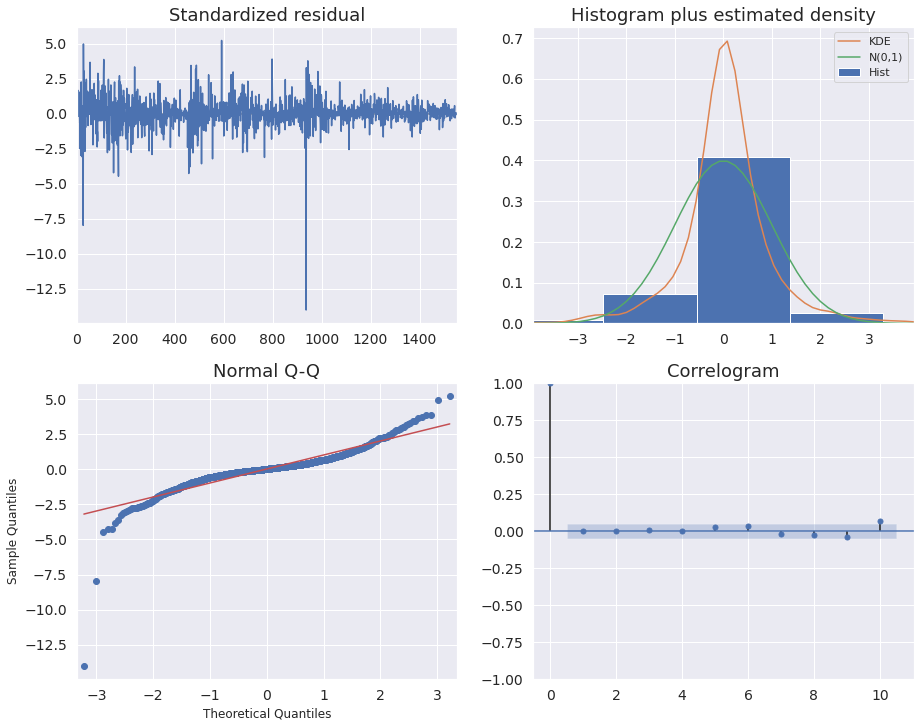

In [145]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

### Prediction

In [146]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [147]:
btc_series.index.sort_values()

DatetimeIndex(['2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20',
               '2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24',
               '2017-08-25', '2017-08-26',
               ...
               '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-11-14', '2021-11-14', '2021-11-14',
               '2021-11-14', '2021-11-14'],
              dtype='datetime64[ns]', name='timestamp', length=1555, freq=None)

Text(0, 0.5, 'USD')

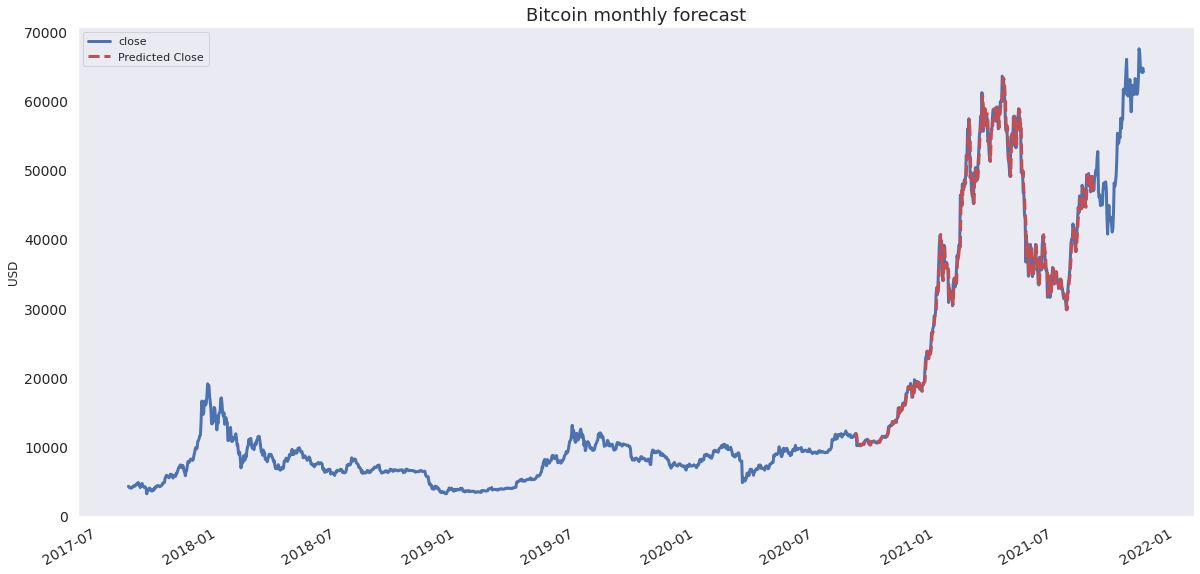

In [149]:
# Prediction
btc_month_pred = btc_series[['close']]
date_list = [datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31)]
future = pd.DataFrame(index=date_list, columns= btc_series.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

btc_month_pred['forecast'] = invboxcox(best_model.predict(
    start=datetime(2020,8,31), end=datetime(2021,8,31)), lmbda)
btc_month_pred.head()
# btc_series.head()
btc_month_pred.close.astype(float).plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', 
                             label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')

In [150]:
SEQ_LEN = 60  
FUTURE_PERIOD_PREDICT = 3  
RATIO_TO_PREDICT = "BTC-USD"
main_df = pd.DataFrame() 
def preprocess(df):
  '''
  Function to derive:
  - 'target' field, which is the decision to buy/sell
  - train and validation datasets
  '''

  for col in df.columns:
    if col != 'target':
      df[col] = np.array(df[col], dtype=float) 
      df[col] = df[col].pct_change()
      df.dropna(inplace=True)
      df[col] = preprocessing.scale(df[col].values)

  df.dropna(inplace=True)

  sequential_data = []
  prev_days = deque()

  for i in df.values:  
        prev_days.append([n for n in i[:-1]])  
        if len(prev_days) == SEQ_LEN:  
            sequential_data.append([np.array(prev_days), i[-1]])   

  buys = []
  sells = []  
    
  #if the target is 1 then it is a buy else it is sells
  
  for seq, target in sequential_data:  
      if target == 0:  
          sells.append([seq, target])  
      elif target == 1:  
          buys.append([seq, target])  

  #shuffle for good measures
  random.shuffle(buys)  
  random.shuffle(sells) 

  lower = min(len(buys), len(sells))  

  buys = buys[:lower]  
  sells = sells[:lower]  

  sequential_data = buys+sells  
  random.shuffle(sequential_data)  
  
  sequences = []
  targets = []

  for seq, target in sequential_data:  
      sequences.append(seq)  
      targets.append(target)  

  return np.array(sequences,dtype=float), targets  




In [159]:
main_df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy base asset volume,taker buy quote asset volume,_
timestamp,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.15,1503014399999,3.45477e+06,3427,616.249,2.67822e+06,8733.91
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.89,1503100799999,5.08696e+06,5233,972.869,4.12912e+06,9384.14
2017-08-19,4108.37,4184.69,3850,4139.98,381.31,1503187199999,1.54948e+06,2153,274.336,1.118e+06,9184.09
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083,1503273599999,1.93036e+06,2321,376.796,1.5574e+06,10125.4
2017-08-21,4069.13,4119.62,3911.79,4016,691.743,1503359999999,2.79723e+06,3972,557.356,2.25566e+06,11706.8


In [160]:
main_df.fillna(method='ffill', inplace=True)
main_df.dropna(inplace=True)

main_df['future'] = main_df['close'].shift(-FUTURE_PERIOD_PREDICT)
main_df['target'] = list(map(classify, 
                                              main_df['close'], 
                                              main_df['future']))
main_df.dropna(inplace=True)
# main_df.head()
#Taking last 10% only for good measures

times = sorted(main_df.index.values)
last_pct = sorted(main_df.index.values)[-int(0.10*len(times))]

validation_main_df = main_df[(main_df.index >= last_pct)]
main_df = main_df[(main_df.index < last_pct)]

print(main_df.head())

               open     high      low  ...        _   future  target
timestamp                              ...                          
2017-08-17  4261.48  4485.39  4200.74  ...  8733.91  4086.29       0
2017-08-18  4285.08  4371.52  3938.77  ...  9384.14     4016       0
2017-08-19  4108.37  4184.69     3850  ...  9184.09     4040       0
2017-08-20  4120.98  4211.08  4032.62  ...  10125.4  4114.01       1
2017-08-21  4069.13  4119.62  3911.79  ...  11706.8  4316.01       1

[5 rows x 13 columns]


In [161]:
btc_data_1d.fillna(method='ffill', inplace=True)
btc_data_1d.dropna(inplace=True)

btc_data_1d['future'] = btc_data_1d['close'].shift(-FUTURE_PERIOD_PREDICT)
btc_data_1d['target'] = list(map(classify, 
                                              btc_data_1d['close'], 
                                              btc_data_1d['future']))
btc_data_1d.dropna(inplace=True)

#Taking last 10% only for good measures

times = sorted(btc_data_1d.index.values)
last_pct = sorted(btc_data_1d.index.values)[-int(0.10*len(times))]

validation_main_df = btc_data_1d[(btc_data_1d.index >= last_pct)]
btc_data_1d = btc_data_1d[(btc_data_1d.index < last_pct)]

print(btc_data_1d.head())

               open     high      low  ...        _   future  target
timestamp                              ...                          
2017-08-17  4261.48  4485.39  4200.74  ...  8733.91  4086.29       0
2017-08-18  4285.08  4371.52  3938.77  ...  9384.14     4016       0
2017-08-19  4108.37  4184.69     3850  ...  9184.09     4040       0
2017-08-20  4120.98  4211.08  4032.62  ...  10125.4  4114.01       1
2017-08-21  4069.13  4119.62  3911.79  ...  11706.8  4316.01       1

[5 rows x 13 columns]


In [171]:
train_x = btc_data_1d.loc[:, btc_data_1d.columns != 'target']
train_y = btc_data_1d['target']

validation_x = validation_main_df.loc[:, validation_main_df.columns != 'target']
validation_y = validation_main_df['target']

train_x = np.asarray(train_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')


validation_x = np.asarray(validation_x).astype('float32')
validation_y = np.asarray(validation_y).astype('float32')


In [ ]:
validation_x

In [167]:
print(np.shape(train_x))
print(np.shape(train_y))

print(np.shape(validation_main_df))
print(np.shape(validation_x))
print(np.shape(validation_y))

(1397, 12)
(1397,)
(155, 13)
(155, 12)
(155,)
